# Fitting Radio Data with emcee
This notebook illustrates a simple suite of routines for performing an MCMC fit to radio data.

## Preliminaries
Load libraries, set default parameters for emcee

In [2]:
import numpy as np
from astropy import units as u
from astropy import constants as c

# Preferred defaults for plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
# rc('text', usetex=True) # TeX fonts
res_dpi = 300
ext = 'png'

import emcee, corner
nwalkers = 100
nsteps = 4000
nburn = 1000

## Emission Models
### Dust
$I_\nu = A_d \left( \frac{\nu}{353\,{\rm GHz}} \right)^\beta B_\nu\left(T_d\right)$

Note: normalized to a reference frequency of 353 GHz.

In [3]:
def B_nu(nu, T): # Planck function
    np.seterr(over='ignore')
    return 2.0*c.h*(nu**3)/(c.c**2*(np.expm1(c.h*nu/(c.k_B*T))))

def I_dust(nu, Td, beta, Ad):
    return Ad*(nu/(353.*u.GHz))**beta*B_nu(nu,Td)/B_nu(353*u.GHz,Td)

### Free-free
$I_\nu = A_{ff} \frac{g_{ff}\left(\nu, T\right)}{g_{ff}\left(30\,{\rm GHz}, T\right)}$

where $g_{ff}$ is the Gaunt factor

In [4]:
def I_ff(nu, T, Aff):
    def gff(nu, T):
        T4 = T/(1.e4*u.K)
        nu9 = nu/(1.*u.GHz)
        gnu = np.log(np.exp(5.960 - (np.sqrt(3.)/np.pi)*np.log(nu9*(T4**(-3./2.)))) + np.exp(1.))
        return gnu   
    
    return Aff*gff(nu,T)/gff(30.*u.GHz,T)

### Synchrotron
$I_\nu = A_s \left( \frac{\nu}{30\,{\rm GHz}} \right)^\alpha$

In [5]:
def I_sync(nu, alpha, As):
    return As*(nu/(30.*u.GHz))**alpha

## Likelihood Function and MCMC Setup
This is set up to fit the synchrotron index $\alpha$ and the amplitudes of synchrotron ($A_s$_, dust ($A_d$), and free-free ($A_{ff}$). All other parameters will be held to fixed values.

In [6]:
def full_fit(xdata, ydata, yerr, mcmc_params):
    ndim, nwalkers, nsteps, nburn = mcmc_params
    
    def lnprior(theta):
        alpha, As, Ad, Aff = theta

        # Amplitude parameters cannot be negative
        if As < 0. or Ad < 0. or Aff < 0.:
            return -np.inf
        #gaussian prior on alpha
        mu=-0.83
        sigma=0.13
        return np.log(1.0/(np.sqrt(2*np.pi)*sigma))-0.5*(alpha-mu)**2/sigma**2

    def lnlike(theta, x, y, yerr):
        alpha, As, Ad, Aff = theta
        Is = I_sync(x, alpha, As*u.mJy)
        Id = I_dust(x, 20.*u.K, 1.50, Ad*u.mJy)
        Iff = I_ff(x, 1.e4*u.K, Aff*u.mJy)
        model = Is + Id + Iff
        return -0.5*(np.sum((y - model)**2/yerr**2 + np.log(2.*np.pi*yerr.value**2)))

    def lnprob(theta, x, y, yerr):
        lp = lnprior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + lnlike(theta, x, y, yerr)

    # Initialize with guess
    pos = [[-1., 1., 1., 1.] 
           + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]

    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(xdata, ydata, yerr))
    sampler.run_mcmc(pos, nsteps)
    samples = sampler.chain[:, nburn:, :].reshape((-1, ndim))

    return samples

## Read in the data, run the MCMC, and create final figures

In [11]:
import os
from astropy.table import Table, Column
import sys
import h5py

path='/lustre/cv/students/adignan/data/mcmcfiles/'

alpha1=[]
alpha2=[]
alpha3=[]

as1=[]
as2=[]
as3=[]

ad1=[]
ad2=[]
ad3=[]

aff1=[]
aff2=[]
aff3=[]

files=[]

exclude=['.ipynb_checkpoints', 'unfittable','annas_radio_fit.ipynb',
        'dustless_annas_radio_fit.ipynb','radio_fit.ipynb','thermalfrac.ipynb',
        'mcmc_plotting.ipynb']

results=Table()

for file in os.listdir(path):
    if file == 'NGC4579':
        if file not in exclude:
            print('Working on file ' +str(file))
            (nu, fnu, sfnu) = np.genfromtxt(path+str(file), unpack=True)
            nu *= u.GHz
            fnu *= u.mJy
            sfnu *= u.mJy

            ndim = 4
            mcmc_params = (ndim, nwalkers, nsteps, nburn)
            samples = full_fit(nu, fnu, sfnu, mcmc_params)

            alpha_mcmc, As_mcmc, Ad_mcmc, Aff_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
            
            fig_mcmc = corner.corner(samples, labels=[r'$\alpha$', r'$A_s$', r'$A_d$',
                                                     r'$A_{ff}$'],
                                    truths=[alpha_mcmc[0], As_mcmc[0], Ad_mcmc[0], Aff_mcmc[0]])

            fig_mcmc.savefig('/users/adignan/triangle_' + str(file) +'.' + ext,format=ext,dpi=res_dpi,bbox_inches='tight')

            plt.close()

            files.append(str(file))

            alpha1.append(alpha_mcmc[0])
            alpha2.append(alpha_mcmc[1])
            alpha3.append(alpha_mcmc[2])

            as1.append(As_mcmc[0])
            as2.append(As_mcmc[1])
            as3.append(As_mcmc[2])

            ad1.append(Ad_mcmc[0])
            ad2.append(Ad_mcmc[1])
            ad3.append(Ad_mcmc[2])

            aff1.append(Aff_mcmc[0])
            aff2.append(Aff_mcmc[1])
            aff3.append(Aff_mcmc[2])

            hf = h5py.File('/users/adignan/'+str(file)+'-samples.h5', 'w')
            hf.create_dataset('dataset', data=samples)
            hf.close
            #             fig, ax = plt.subplots(1,1,figsize=(3.5, 3))
            #             ax.set_xscale('log')
            #             ax.set_yscale('log')
            #             ax.set_xlabel(r'$\nu\ [\rm GHz]$',fontsize=12)
            #             ax.set_ylabel(r'$S_\nu\ [{\rm mJy}]$',fontsize=12)
            #             ax.tick_params(axis='both', which='major', labelsize=11)
            #             ax.axis([1., 1000., 0.1, 10.])
            #             ax.tick_params(axis='both', which='both', labelsize=11,
            #                              bottom=True, top=True, left=True, right=True,
            #                              direction='in')

            #             ax2 = ax.twiny()
            #             plt.xscale('log')
            #             ax2.set_xlabel(r'$\lambda\ [\rm cm]$',fontsize=12)
            #             ax2.set_xlim(ax.get_xlim())
            #             ax2.set_xticks([(c.c/(0.2*u.cm)).to(u.GHz).value, (c.c/(1.*u.cm)).to(u.GHz).value, 
            #                             (c.c/(10.*u.cm)).to(u.GHz).value])
            #             ax2.set_xticklabels([r'$0.2$',r'$1$',r'$10$'])
            #             ax2.tick_params(labelsize=11)

            #             # Photometry
            #             ax.errorbar(nu,fnu,sfnu,color='k',linestyle='',marker='o',markersize=2,label=r'${\rm Data}$')


            #             # Emission components
            #             nu_out = np.logspace(0.,3.,1000)*u.GHz  
            #             snu_sync = I_sync(nu_out, alpha_mcmc[0], As_mcmc[0])
            #             snu_dust = I_dust(nu_out, 20.*u.K, 1.50, Ad_mcmc[0])
            #             snu_ff = I_ff(nu_out, 1.e4*u.K, Aff_mcmc[0])
            #             snu_model = snu_sync + snu_ff + snu_dust

            #             ax.plot(nu_out,snu_sync,color='b',linestyle='--',label=r'${\rm Synchrotron}$',alpha=1.)
            #             ax.plot(nu_out,snu_ff,color='#1b9e77',linestyle=':',label=r'${\rm Free–Free}$',alpha=1.)
            #             ax.plot(nu_out,snu_dust,color='#d95f02',linestyle='--',label=r'${\rm Dust}$',alpha=1.)
            #             ax.plot(nu_out,snu_model,color='k',linestyle='-',label=r'${\rm Model}$',alpha=0.5)

            #             handles, labels = ax.get_legend_handles_labels()
            #             order = [0,1,2,3]
            #             leg1 = ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
            #                                      loc='upper left', prop={'size': 7}, frameon=False, numpoints=1)

            #             fig.savefig('/users/adignan/figures/models_take2/fit_model_' + str(file) +'.' + ext,format=ext,dpi=res_dpi,bbox_inches='tight')

            #             plt.close()

#define columns to add to our results table
alpha1col=Column(alpha1,name='alpha median')
alpha2col=Column(alpha2,name='alpha one sigma + error')
alpha3col=Column(alpha3,name='alpha one sigma – error')

as1col=Column(as1,name='A_s median')
as2col=Column(as2,name='A_s one sigma + error')
as3col=Column(as3,name='A_s one sigma – error')

ad1col=Column(ad1,name='A_d median')
ad2col=Column(ad2,name='A_d one sigma + error')
ad3col=Column(ad3,name='A_d one sigma – error')

aff1col=Column(aff1,name='A_ff median')
aff2col=Column(aff2,name='A_ff one sigma + error')
aff3col=Column(aff3,name='A_ff one sigma – error')

filecol=Column(files,name='Source ID')

#add columns to our results table
results.add_columns([filecol,alpha1col,alpha2col,alpha3col,as1col,as2col,as3col,
                    ad1col,ad2col,ad3col,aff1col,aff2col,aff3col])

results.write('/users/adignan/NGC4579.csv',overwrite=True)

Working on file NGC4579


# Create figures assuming you've already run the MCMC and have the results saved somewhere

Working on file NGC4579
detection!
detection!
detection!
detection!


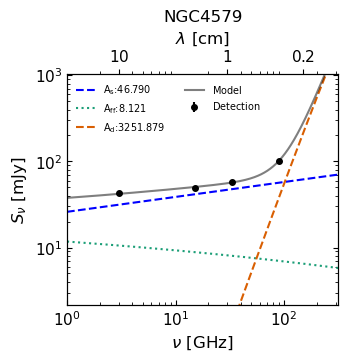

In [15]:
import pandas as pd
import sys
import os
import numpy as np
from astropy.io import ascii
from astropy import units as u
from astropy import constants as c
import matplotlib.pyplot as plt

path='/lustre/cv/students/adignan/data/mcmcfiles/'
results=ascii.read('/users/adignan/NGC4579.csv',format='csv')


###
# sample=['NGC0337c', 'NGC0628Enuc.2', 'NGC0925', 'NGC4254a', 'NGC4254d', 'NGC4254e', 
#         'NGC4725a', 'NGC4254Enuc.1b', 'NGC4625', 'NGC5194Enuc.11a', 'NGC5194Enuc.1c', 
#         'NGC5194Enuc.4b', 'NGC5194Enuc.4c', 'NGC5194Enuc.4d', 'NGC5194Enuc.5a']

for file in os.listdir(path):
    if file == 'NGC4579':
        for row in results:
            if file == str(row['Source ID']):
                print('Working on file ' +str(file))
                (nu, fnu, sfnu) = np.genfromtxt(path+str(file), unpack=True)
                nu *= u.GHz
                fnu *= u.mJy
                sfnu *= u.mJy

                fig, ax = plt.subplots(1,1,figsize=(3.5, 3))
                ax.set_title(str(row['Source ID']))
                ax.set_xscale('log')
                ax.set_yscale('log')
#                 ax.set_yscale('symlog')
                ax.set_xlabel(r'$\nu\ [\rm GHz]$',fontsize=12)
                ax.set_ylabel(r'$S_\nu\ [{\rm mJy}]$',fontsize=12)
                ax.tick_params(axis='both', which='major', labelsize=11)
                ax.axis([1., 10**(2.5), 0.05*np.min(fnu).value, 10*np.max(fnu).value])
                ax.tick_params(axis='both', which='both', labelsize=11,
                                 bottom=True, top=True, left=True, right=True,
                                 direction='in')

                ax2 = ax.twiny()
                plt.xscale('log')
                ax2.set_xlabel(r'$\lambda\ [\rm cm]$',fontsize=12)
                ax2.set_xlim(ax.get_xlim())
                ax2.set_xticks([(c.c/(0.2*u.cm)).to(u.GHz).value, (c.c/(1.*u.cm)).to(u.GHz).value, 
                                (c.c/(10.*u.cm)).to(u.GHz).value])
                ax2.set_xticklabels([r'$0.2$',r'$1$',r'$10$'])
                ax2.tick_params(labelsize=11)

                # Photometry
#                 ax.errorbar(nu,fnu,sfnu,color='k',linestyle='',marker='o',markersize=2,label=r'${\rm Data}$')
                for n,f,s in zip(nu,fnu,sfnu):
                    if f/s > 3:
                        print('detection!')
                        ax.errorbar(n,f,s,color='k',linestyle='',marker='o',markersize=4,label=r'${\rm Detection}$')
                    if f/s < 3:
                        print('nondetection!')
                        ax.errorbar(n,f,s,color='red',linestyle='',marker='v',markersize=4,label=r'${\rm Nondetection}$')

                # Emission components
                nu_out = np.logspace(0.,3.,1000)*u.GHz  
                snu_sync = I_sync(nu_out, (row['alpha median']), (row['A_s median']))
                snu_dust = I_dust(nu_out, 20.*u.K, 1.50, (row['A_d median']))
                snu_ff = I_ff(nu_out, 1.e4*u.K, (row['A_ff median']))
                snu_model = snu_sync + snu_ff + snu_dust

                ax.plot(nu_out,snu_sync,color='b',linestyle='--',label=r'${\rm A_{s}}$:'+"%.3f" % (row['A_s median']),alpha=1.)
                # ax.plot(nu_out,snu_sync,color='b',linestyle='--',label=r'${\rm A_{s}}$:' '2.792e52',alpha=1.)
                ax.plot(nu_out,snu_ff,color='#1b9e77',linestyle=':',label=r'${\rm A_{ff}}$:'+"%.3f" % (row['A_ff median']),alpha=1.)
                ax.plot(nu_out,snu_dust,color='#d95f02',linestyle='--',label=r'${\rm A_{d}}$:'+"%.3f" % (row['A_d median']),alpha=1.)
                ax.plot(nu_out,snu_model,color='k',linestyle='-',label=r'${\rm Model}$',alpha=0.5)

                handles, labels = ax.get_legend_handles_labels()
                order = [0,1,2,3,4]
                leg1 = ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
                                         loc='upper left', prop={'size': 7}, frameon=False, numpoints=1,ncol=2)

                fig.savefig('/users/adignan/fit_model_' + str(file) +'.' + ext,format=ext,dpi=res_dpi,bbox_inches='tight')

                plt.show()

                # plt.close()

In [14]:
hf = h5py.File('/lustre/cv/students/adignan/data/hdf5/NGC5194e-samples.h5', 'r')
n1 = hf.get('dataset')
n1=np.array(n1)
print(n1)

[[-0.84364096  2.01345679  1.01393851  0.09475418]
 [-0.84081338  2.02923277  0.86243357  0.09016865]
 [-0.84285896  2.02083436  0.58416098  0.07855762]
 ...
 [-0.86585264  1.87674959  2.45974164  0.15288678]
 [-0.86585264  1.87674959  2.45974164  0.15288678]
 [-0.88364365  1.77491033  3.03263812  0.21009238]]


In [28]:

path='/users/adignan/mcmcfiles/'

exclude=['.ipynb_checkpoints', 'unfittable','annas_radio_fit.ipynb',
        'dustless_annas_radio_fit.ipynb','radio_fit.ipynb','thermalfrac.ipynb']

for file in os.listdir(path):
    if file not in exclude:
        print(file)

NGC0337c
NGC0628Enuc.1
NGC0628Enuc.2
NGC0628Enuc.3
NGC0628Enuc.4
NGC0925
NGC3627
NGC3627Enuc.1
NGC3938Enuc.2b
NGC4254a
NGC4254c
NGC4254d
NGC4254e
NGC4725a
NGC6946Enuc.2a
NGC6946Enuc.3a
NGC6946Enuc.4b
NGC6946Enuc.5b
NGC0337a
NGC0337b
NGC0337d
NGC2798
NGC2841
NGC3049
NGC3184
NGC3190
NGC3198
NGC3351a
NGC3351b
NGC3627Enuc.2
NGC3773
NGC4254b
NGC4321a
NGC4321b
NGC4569
NGC4579
NGC4594a
NGC6946Enuc.2b
NGC6946Enuc.3b
NGC6946Enuc.4a
NGC6946Enuc.4c
NGC6946Enuc.6a
NGC6946Enuc.6b
NGC6946Enuc.7
NGC6946Enuc.8
NGC6946Enuc.9
NGC6946a
NGC6946b
NGC6946c
NGC2146a
NGC2146b
NGC2146c
NGC4254Enuc.1b
NGC4254Enuc.1c
NGC4536
NGC4559b
NGC4559c
NGC4625
NGC4631Enuc.2b
NGC4631a
NGC4631b
NGC4631c
NGC4631d
NGC4631e
NGC5194Enuc.10b
NGC5194Enuc.11a
NGC5194Enuc.11e
NGC5194Enuc.1a
NGC5194Enuc.1b
NGC5194Enuc.1c
NGC5194Enuc.2
NGC5194Enuc.3
NGC5194Enuc.4b
NGC5194Enuc.4c
NGC5194Enuc.4d
NGC5194Enuc.5a
NGC5194Enuc.6a
NGC5194Enuc.7b
NGC5194Enuc.8
NGC5194a
NGC5194b
NGC5194c
NGC5194d
NGC5194e
